<a href="https://colab.research.google.com/github/open-mmlab/mmpose/blob/master/demo/MMPose_Tutorial.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MMPose Tutorial

Welcome to MMPose colab tutorial! In this tutorial, we will show you how to
- perform inference with an MMPose model
- train a new mmpose model with your own datasets

Let's start!

## Install MMPose

We recommend to use a conda environment to install mmpose and its dependencies. And compilers `nvcc` and `gcc` are required.

In [1]:
# check NVCC version
!nvcc -V

# check GCC version
!gcc --version

# check python in conda environment
!which python

nvcc: NVIDIA (R) Cuda compiler driver
Copyright (c) 2005-2022 NVIDIA Corporation
Built on Wed_Sep_21_10:41:10_Pacific_Daylight_Time_2022
Cuda compilation tools, release 11.8, V11.8.89
Build cuda_11.8.r11.8/compiler.31833905_0


'gcc' is not recognized as an internal or external command,
operable program or batch file.
'which' is not recognized as an internal or external command,
operable program or batch file.


In [2]:
# install dependencies: (use cu111 because colab has CUDA 11.1)
# %pip install torch==1.10.0+cu118 torchvision==0.11.0+cu118 -f https://download.pytorch.org/whl/torch_stable.html

# install mmcv-full thus we could use CUDA operators
# %pip install mmcv-full -f https://download.openmmlab.com/mmcv/dist/cu111/torch1.10.0/index.html

# install mmdet for inference demo
%pip install mmdet

# clone mmpose repo
# %del -rf mmpose
# !git clone https://github.com/open-mmlab/mmpose.git
# %cd mmpose

# install mmpose dependencies
%pip install -r requirements.txt

# install mmpose in develop mode
%pip install -e .

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


ERROR: Could not open requirements file: [Errno 2] No such file or directory: 'requirements.txt'


Obtaining file:///E:/AI_basketball_games_video_editor/AI_basketball_games_video_editor/mmpose/demo
Note: you may need to restart the kernel to use updated packages.


ERROR: file:///E:/AI_basketball_games_video_editor/AI_basketball_games_video_editor/mmpose/demo does not appear to be a Python project: neither 'setup.py' nor 'pyproject.toml' found.


In [3]:
# Check Pytorch installation
import torch, torchvision

print('torch version:', torch.__version__, torch.cuda.is_available())
print('torchvision version:', torchvision.__version__)

# Check MMPose installation
import mmpose

print('mmpose version:', mmpose.__version__)

# Check mmcv installation
from mmcv.ops import get_compiling_cuda_version, get_compiler_version

print('cuda version:', get_compiling_cuda_version())
print('compiler information:', get_compiler_version())

torch version: 2.0.0.dev20230203+cu118 True
torchvision version: 0.15.0.dev20230204+cu118
mmpose version: 0.29.0
cuda version: 11.8
compiler information: MSVC 193532216


C:\Users\varun\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\mmcv\__init__.py:20: UserWarning: On January 1, 2023, MMCV will release v2.0.0, in which it will remove components related to the training process and add a data transformation module. In addition, it will rename the package names mmcv to mmcv-lite and mmcv-full to mmcv. See https://github.com/open-mmlab/mmcv/blob/master/docs/en/compatibility.md for more details.
  warnings.warn(


## Inference with an MMPose model

MMPose provides high level APIs for model inference and training.

load checkpoint from http path: https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth
load checkpoint from http path: https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth
80
[[1604.379150390625, 457.4835510253906, 0.92536860704422], [1606.1175537109375, 452.2683410644531, 0.9488248229026794], [1604.379150390625, 452.2683410644531, 0.8726959824562073], [1613.071044921875, 454.0067443847656, 0.928068995475769], [1620.024658203125, 454.0067443847656, 0.72031569480896], [1611.3326416015625, 469.6521911621094, 0.9169379472732544], [1635.6700439453125, 471.3905944824219, 0.7709737420082092], [1600.90234375, 495.7279968261719, 0.8526808023452759], [1644.362060546875, 497.4664001464844, 0.551601767539978], [1585.2569580078125, 513.11181640625, 0.8320192694664001], [1654.7923583984375, 525.280517578125, 0.32245826721191406], [1623.5013427734375, 521.8037109375, 0.8003

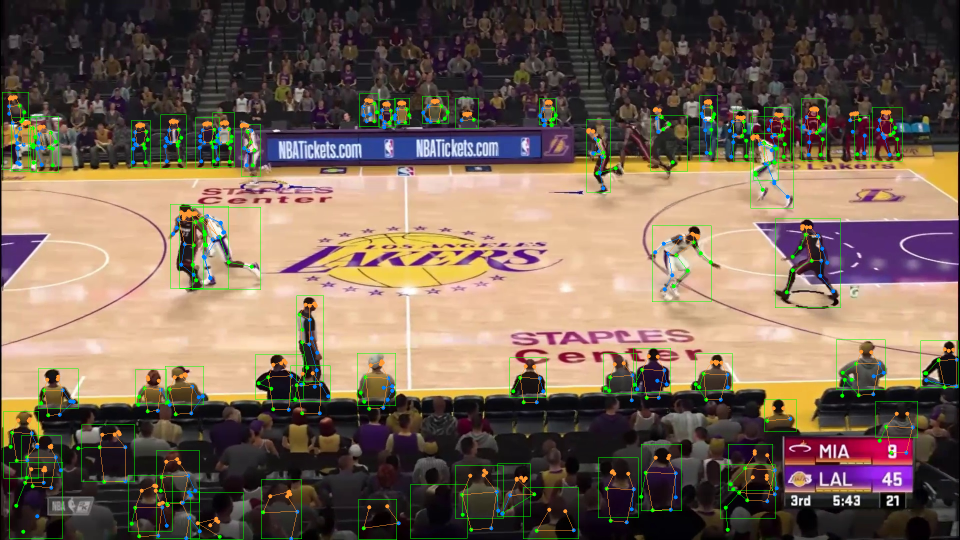

In [61]:
import cv2
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

pose_config = r'E:\AI_basketball_games_video_editor\AI_basketball_games_video_editor\mmpose\configs\body\2d_kpt_sview_rgb_img\topdown_heatmap\coco\hrnet_w48_coco_256x192.py'
pose_checkpoint = 'https://download.openmmlab.com/mmpose/top_down/hrnet/hrnet_w48_coco_256x192-b9e0b3ab_20200708.pth'
det_config = r"E:\AI_basketball_games_video_editor\AI_basketball_games_video_editor\mmpose\demo\mmdetection_cfg\faster_rcnn_r50_fpn_coco.py"
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# initialize pose model
pose_model = init_pose_model(pose_config, pose_checkpoint)

# initialize detector
det_model = init_detector(det_config, det_checkpoint)

img = r'E:\AI_basketball_games_video_editor\AI_basketball_games_video_editor\input\images\frame196.jpg'

# inference detection
mmdet_results = inference_detector(det_model, img)
# print(len(mmdet_results))
# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)
# print(person_results)
print(len(person_results))
# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    img,
    person_results,
    bbox_thr=0.31,
    format='xyxy',
    return_heatmap=False,
    dataset=pose_model.cfg.data.test.type)

print((pose_results[0]['keypoints']).tolist())
print(len(pose_results))

vis_result = vis_pose_result(
    pose_model,
    img,
    pose_results,
    dataset=pose_model.cfg.data.test.type,
    show=False)


# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result)
        display(Image(file_name))
else:
    cv2_imshow(vis_result)


## Train a pose estimation model on a customized dataset

To train a model on a customized dataset with MMPose, there are usually three steps:
1. Support the dataset in MMPose
1. Create a config
1. Perform training and evaluation

### Add a new dataset

There are two methods to support a customized dataset in MMPose. The first one is to convert the data to a supported format (e.g. COCO) and use the corresponding dataset class (e.g. TopdownCOCODataset), as described in the [document](https://mmpose.readthedocs.io/en/latest/tutorials/2_new_dataset.html#reorganize-dataset-to-existing-format). The second one is to add a new dataset class. In this tutorial, we give an example of the second method.

We first download the demo dataset, which contains 100 samples (75 for training and 25 for validation) selected from COCO train2017 dataset. The annotations are stored in a different format from the original COCO format.



In [ ]:
# download dataset
%mkdir data
%cd data
!wget https://download.openmmlab.com/mmpose/datasets/coco_tiny.tar
!tar -xf coco_tiny.tar
%cd ..

mkdir: cannot create directory ‘data’: File exists
/home/PJLAB/liyining/openmmlab/mmpose/data
--2021-09-22 22:27:21--  https://openmmlab.oss-cn-hangzhou.aliyuncs.com/mmpose/datasets/coco_tiny.tar
Resolving openmmlab.oss-cn-hangzhou.aliyuncs.com (openmmlab.oss-cn-hangzhou.aliyuncs.com)... 124.160.145.51
Connecting to openmmlab.oss-cn-hangzhou.aliyuncs.com (openmmlab.oss-cn-hangzhou.aliyuncs.com)|124.160.145.51|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16558080 (16M) [application/x-tar]
Saving to: ‘coco_tiny.tar.1’

coco_tiny.tar.1     100%[===================>]  15.79M  14.7MB/s    in 1.1s    

2021-09-22 22:27:24 (14.7 MB/s) - ‘coco_tiny.tar.1’ saved [16558080/16558080]

/home/PJLAB/liyining/openmmlab/mmpose


In [ ]:
# check the directory structure
!apt-get -q install tree
!tree data/coco_tiny

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?
data/coco_tiny
├── images
│   ├── 000000012754.jpg
│   ├── 000000017741.jpg
│   ├── 000000019157.jpg
│   ├── 000000019523.jpg
│   ├── 000000019608.jpg
│   ├── 000000022816.jpg
│   ├── 000000031092.jpg
│   ├── 000000032124.jpg
│   ├── 000000037209.jpg
│   ├── 000000050713.jpg
│   ├── 000000057703.jpg
│   ├── 000000064909.jpg
│   ├── 000000076942.jpg
│   ├── 000000079754.jpg
│   ├── 000000083935.jpg
│   ├── 000000085316.jpg
│   ├── 000000101013.jpg
│   ├── 000000101172.jpg
│   ├── 000000103134.jpg
│   ├── 000000103163.jpg
│   ├── 000000105647.jpg
│   ├── 000000107960.jpg
│   ├── 000000117891.jpg
│   ├── 000000118181.jpg
│   ├── 000000120021.jpg
│   ├── 000000128119.jpg
│   ├── 000000143908.jpg
│   ├── 000000145025.jpg
│   ├── 000000147386.jpg
│   ├── 000000147979.jpg
│   ├── 000000154222.jpg
│   ├── 000000160190.jp

In [ ]:
# check the annotation format
import json
import pprint

anns = json.load(open('data/coco_tiny/train.json'))

print(type(anns), len(anns))
pprint.pprint(anns[0], compact=True)


<class 'list'> 75
{'bbox': [267.03, 104.32, 229.19, 320],
 'image_file': '000000537548.jpg',
 'image_size': [640, 480],
 'keypoints': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 325, 160, 2, 398,
               177, 2, 0, 0, 0, 437, 238, 2, 0, 0, 0, 477, 270, 2, 287, 255, 1,
               339, 267, 2, 0, 0, 0, 423, 314, 2, 0, 0, 0, 355, 367, 2]}


After downloading the data, we implement a new dataset class to load data samples for model training and validation. Assume that we are going to train a top-down pose estimation model (refer to [Top-down Pose Estimation](https://github.com/open-mmlab/mmpose/tree/master/configs/body/2d_kpt_sview_rgb_img/topdown_heatmap#readme) for a brief introduction), the new dataset class inherits `TopDownBaseDataset`.

In [ ]:
import json
import os.path as osp
from collections import OrderedDict
import tempfile

import numpy as np

from mmpose.core.evaluation.top_down_eval import (keypoint_nme,
                                                  keypoint_pck_accuracy)
from mmpose.datasets.builder import DATASETS
from mmpose.datasets.datasets.base import Kpt2dSviewRgbImgTopDownDataset


@DATASETS.register_module()
class TopDownCOCOTinyDataset(Kpt2dSviewRgbImgTopDownDataset):

    def __init__(self,
                 ann_file,
                 img_prefix,
                 data_cfg,
                 pipeline,
                 dataset_info=None,
                 test_mode=False):
        super().__init__(
            ann_file,
            img_prefix,
            data_cfg,
            pipeline,
            dataset_info,
            coco_style=False,
            test_mode=test_mode)

        # flip_pairs, upper_body_ids and lower_body_ids will be used
        # in some data augmentations like random flip
        self.ann_info['flip_pairs'] = [[1, 2], [3, 4], [5, 6], [7, 8], [9, 10],
                                       [11, 12], [13, 14], [15, 16]]
        self.ann_info['upper_body_ids'] = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10)
        self.ann_info['lower_body_ids'] = (11, 12, 13, 14, 15, 16)

        self.ann_info['joint_weights'] = None
        self.ann_info['use_different_joint_weights'] = False

        self.dataset_name = 'coco_tiny'
        self.db = self._get_db()

    def _get_db(self):
        with open(self.ann_file) as f:
            anns = json.load(f)

        db = []
        for idx, ann in enumerate(anns):
            # get image path
            image_file = osp.join(self.img_prefix, ann['image_file'])
            # get bbox
            bbox = ann['bbox']
            # get keypoints
            keypoints = np.array(
                ann['keypoints'], dtype=np.float32).reshape(-1, 3)
            num_joints = keypoints.shape[0]
            joints_3d = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d[:, :2] = keypoints[:, :2]
            joints_3d_visible = np.zeros((num_joints, 3), dtype=np.float32)
            joints_3d_visible[:, :2] = np.minimum(1, keypoints[:, 2:3])

            sample = {
                'image_file': image_file,
                'bbox': bbox,
                'rotation': 0,
                'joints_3d': joints_3d,
                'joints_3d_visible': joints_3d_visible,
                'bbox_score': 1,
                'bbox_id': idx,
            }
            db.append(sample)

        return db

    def evaluate(self, results, res_folder=None, metric='PCK', **kwargs):
        """Evaluate keypoint detection results. The pose prediction results will
        be saved in `${res_folder}/result_keypoints.json`.

        Note:
        batch_size: N
        num_keypoints: K
        heatmap height: H
        heatmap width: W

        Args:
        results (list(preds, boxes, image_path, output_heatmap))
            :preds (np.ndarray[N,K,3]): The first two dimensions are
                coordinates, score is the third dimension of the array.
            :boxes (np.ndarray[N,6]): [center[0], center[1], scale[0]
                , scale[1],area, score]
            :image_paths (list[str]): For example, ['Test/source/0.jpg']
            :output_heatmap (np.ndarray[N, K, H, W]): model outputs.

        res_folder (str, optional): The folder to save the testing
                results. If not specified, a temp folder will be created.
                Default: None.
        metric (str | list[str]): Metric to be performed.
            Options: 'PCK', 'NME'.

        Returns:
            dict: Evaluation results for evaluation metric.
        """
        metrics = metric if isinstance(metric, list) else [metric]
        allowed_metrics = ['PCK', 'NME']
        for metric in metrics:
            if metric not in allowed_metrics:
                raise KeyError(f'metric {metric} is not supported')

        if res_folder is not None:
            tmp_folder = None
            res_file = osp.join(res_folder, 'result_keypoints.json')
        else:
            tmp_folder = tempfile.TemporaryDirectory()
            res_file = osp.join(tmp_folder.name, 'result_keypoints.json')

        kpts = []
        for result in results:
            preds = result['preds']
            boxes = result['boxes']
            image_paths = result['image_paths']
            bbox_ids = result['bbox_ids']

            batch_size = len(image_paths)
            for i in range(batch_size):
                kpts.append({
                    'keypoints': preds[i].tolist(),
                    'center': boxes[i][0:2].tolist(),
                    'scale': boxes[i][2:4].tolist(),
                    'area': float(boxes[i][4]),
                    'score': float(boxes[i][5]),
                    'bbox_id': bbox_ids[i]
                })
        kpts = self._sort_and_unique_bboxes(kpts)

        self._write_keypoint_results(kpts, res_file)
        info_str = self._report_metric(res_file, metrics)
        name_value = OrderedDict(info_str)

        if tmp_folder is not None:
            tmp_folder.cleanup()

        return name_value

    def _report_metric(self, res_file, metrics, pck_thr=0.3):
        """Keypoint evaluation.

        Args:
        res_file (str): Json file stored prediction results.
        metrics (str | list[str]): Metric to be performed.
            Options: 'PCK', 'NME'.
        pck_thr (float): PCK threshold, default: 0.3.

        Returns:
        dict: Evaluation results for evaluation metric.
        """
        info_str = []

        with open(res_file, 'r') as fin:
            preds = json.load(fin)
        assert len(preds) == len(self.db)

        outputs = []
        gts = []
        masks = []

        for pred, item in zip(preds, self.db):
            outputs.append(np.array(pred['keypoints'])[:, :-1])
            gts.append(np.array(item['joints_3d'])[:, :-1])
            masks.append((np.array(item['joints_3d_visible'])[:, 0]) > 0)

        outputs = np.array(outputs)
        gts = np.array(gts)
        masks = np.array(masks)

        normalize_factor = self._get_normalize_factor(gts)

        if 'PCK' in metrics:
            _, pck, _ = keypoint_pck_accuracy(outputs, gts, masks, pck_thr,
                                              normalize_factor)
            info_str.append(('PCK', pck))

        if 'NME' in metrics:
            info_str.append(
                ('NME', keypoint_nme(outputs, gts, masks, normalize_factor)))

        return info_str

    @staticmethod
    def _write_keypoint_results(keypoints, res_file):
        """Write results into a json file."""

        with open(res_file, 'w') as f:
            json.dump(keypoints, f, sort_keys=True, indent=4)

    @staticmethod
    def _sort_and_unique_bboxes(kpts, key='bbox_id'):
        """sort kpts and remove the repeated ones."""
        kpts = sorted(kpts, key=lambda x: x[key])
        num = len(kpts)
        for i in range(num - 1, 0, -1):
            if kpts[i][key] == kpts[i - 1][key]:
                del kpts[i]

        return kpts

    @staticmethod
    def _get_normalize_factor(gts):
        """Get inter-ocular distance as the normalize factor, measured as the
        Euclidean distance between the outer corners of the eyes.

        Args:
            gts (np.ndarray[N, K, 2]): Groundtruth keypoint location.

        Return:
            np.ndarray[N, 2]: normalized factor
        """

        interocular = np.linalg.norm(
            gts[:, 0, :] - gts[:, 1, :], axis=1, keepdims=True)
        return np.tile(interocular, [1, 2])


### Create a config file

In the next step, we create a config file which configures the model, dataset and runtime settings. More information can be found at [Learn about Configs](https://mmpose.readthedocs.io/en/latest/tutorials/0_config.html). A common practice to create a config file is deriving from a existing one. In this tutorial, we load a config file that trains a HRNet on COCO dataset, and modify it to adapt to the COCOTiny dataset.

In [ ]:
from mmcv import Config

cfg = Config.fromfile(
    './configs/body/2d_kpt_sview_rgb_img/topdown_heatmap/coco/hrnet_w32_coco_256x192.py'
)

# set basic configs
cfg.data_root = 'data/coco_tiny'
cfg.work_dir = 'work_dirs/hrnet_w32_coco_tiny_256x192'
cfg.gpu_ids = range(1)
cfg.seed = 0

# set log interval
cfg.log_config.interval = 1

# set evaluation configs
cfg.evaluation.interval = 10
cfg.evaluation.metric = 'PCK'
cfg.evaluation.save_best = 'PCK'

# set learning rate policy
lr_config = dict(
    policy='step',
    warmup='linear',
    warmup_iters=10,
    warmup_ratio=0.001,
    step=[17, 35])
cfg.total_epochs = 40

# set batch size
cfg.data.samples_per_gpu = 16
cfg.data.val_dataloader = dict(samples_per_gpu=16)
cfg.data.test_dataloader = dict(samples_per_gpu=16)

# set dataset configs
cfg.data.train.type = 'TopDownCOCOTinyDataset'
cfg.data.train.ann_file = f'{cfg.data_root}/train.json'
cfg.data.train.img_prefix = f'{cfg.data_root}/images/'

cfg.data.val.type = 'TopDownCOCOTinyDataset'
cfg.data.val.ann_file = f'{cfg.data_root}/val.json'
cfg.data.val.img_prefix = f'{cfg.data_root}/images/'

cfg.data.test.type = 'TopDownCOCOTinyDataset'
cfg.data.test.ann_file = f'{cfg.data_root}/val.json'
cfg.data.test.img_prefix = f'{cfg.data_root}/images/'

print(cfg.pretty_text)


dataset_info = dict(
    dataset_name='coco',
    paper_info=dict(
        author=
        'Lin, Tsung-Yi and Maire, Michael and Belongie, Serge and Hays, James and Perona, Pietro and Ramanan, Deva and Doll{\'a}r, Piotr and Zitnick, C Lawrence',
        title='Microsoft coco: Common objects in context',
        container='European conference on computer vision',
        year='2014',
        homepage='http://cocodataset.org/'),
    keypoint_info=dict({
        0:
        dict(name='nose', id=0, color=[51, 153, 255], type='upper', swap=''),
        1:
        dict(
            name='left_eye',
            id=1,
            color=[51, 153, 255],
            type='upper',
            swap='right_eye'),
        2:
        dict(
            name='right_eye',
            id=2,
            color=[51, 153, 255],
            type='upper',
            swap='left_eye'),
        3:
        dict(
            name='left_ear',
            id=3,
            color=[51, 153, 255],
            type='upper

### Train and Evaluation


In [ ]:
from mmpose.datasets import build_dataset
from mmpose.models import build_posenet
from mmpose.apis import train_model
import mmcv

# build dataset
datasets = [build_dataset(cfg.data.train)]

# build model
model = build_posenet(cfg.model)

# create work_dir
mmcv.mkdir_or_exist(cfg.work_dir)

# train model
train_model(
    model, datasets, cfg, distributed=False, validate=True, meta=dict())

Use load_from_http loader


Downloading: "https://download.openmmlab.com/mmpose/pretrain_models/hrnet_w32-36af842e.pth" to /home/PJLAB/liyining/.cache/torch/hub/checkpoints/hrnet_w32-36af842e.pth


  0%|          | 0.00/126M [00:00<?, ?B/s]

2021-09-22 22:37:43,193 - mmpose - WARNING - The model and loaded state dict do not match exactly

unexpected key in source state_dict: head.0.0.0.conv1.weight, head.0.0.0.bn1.weight, head.0.0.0.bn1.bias, head.0.0.0.bn1.running_mean, head.0.0.0.bn1.running_var, head.0.0.0.bn1.num_batches_tracked, head.0.0.0.conv2.weight, head.0.0.0.bn2.weight, head.0.0.0.bn2.bias, head.0.0.0.bn2.running_mean, head.0.0.0.bn2.running_var, head.0.0.0.bn2.num_batches_tracked, head.0.0.0.conv3.weight, head.0.0.0.bn3.weight, head.0.0.0.bn3.bias, head.0.0.0.bn3.running_mean, head.0.0.0.bn3.running_var, head.0.0.0.bn3.num_batches_tracked, head.0.0.0.downsample.0.weight, head.0.0.0.downsample.1.weight, head.0.0.0.downsample.1.bias, head.0.0.0.downsample.1.running_mean, head.0.0.0.downsample.1.running_var, head.0.0.0.downsample.1.num_batches_tracked, head.0.1.0.conv1.weight, head.0.1.0.bn1.weight, head.0.1.0.bn1.bias, head.0.1.0.bn1.running_mean, head.0.1.0.bn1.running_var, head.0.1.0.bn1.num_batches_tracked, he

[                                                  ] 0/25, elapsed: 0s, ETA:

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 43.4 task/s, elapsed: 1s, ETA:     0s

2021-09-22 22:38:25,434 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_10.pth.
2021-09-22 22:38:25,434 - mmpose - INFO - Best PCK is 0.2753 at 10 epoch.
2021-09-22 22:38:25,435 - mmpose - INFO - Epoch(val) [10][2]	PCK: 0.2753
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
2021-09-22 22:38:28,080 - mmpose - INFO - Epoch [11][1/4]	lr: 4.046e-05, eta: 0:01:55, time: 2.639, data_time: 2.248, memory: 2903, mse_loss: 0.0018, acc_pose: 0.1022, loss: 0.0018
2021-09-22 22:38:28,448 - mmpose - INFO - Epoch [11][2/4]	lr: 4.146e-05, eta: 0:01:53, time: 0.368, data_time: 0.002, memory: 2903, mse_loss: 0.0018, acc_pose: 0.0652, loss: 0.0018
2021-09-22 22:38:28,813 - mmpose - INFO - Epoch [11][3/4]	lr: 4.246e-05, eta: 0:01:50, time: 0.365, data_time: 0.001, memory: 2903, mse_loss: 0.0019, acc_pose: 0.1531, loss: 0.0019
2021-09-22 22:38:29

[                                                  ] 0/25, elapsed: 0s, ETA:

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 45.0 task/s, elapsed: 1s, ETA:     0s

2021-09-22 22:39:04,788 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_20.pth.
2021-09-22 22:39:04,789 - mmpose - INFO - Best PCK is 0.3123 at 20 epoch.
2021-09-22 22:39:04,789 - mmpose - INFO - Epoch(val) [20][2]	PCK: 0.3123
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
2021-09-22 22:39:07,402 - mmpose - INFO - Epoch [21][1/4]	lr: 8.042e-05, eta: 0:01:15, time: 2.609, data_time: 2.218, memory: 2903, mse_loss: 0.0017, acc_pose: 0.2806, loss: 0.0017
2021-09-22 22:39:07,769 - mmpose - INFO - Epoch [21][2/4]	lr: 8.142e-05, eta: 0:01:13, time: 0.366, data_time: 0.002, memory: 2903, mse_loss: 0.0017, acc_pose: 0.2352, loss: 0.0017
2021-09-22 22:39:08,136 - mmpose - INFO - Epoch [21][3/4]	lr: 8.242e-05, eta: 0:01:12, time: 0.367, data_time: 0.001, memory: 2903, mse_loss: 0.0021, acc_pose: 0.2968, loss: 0.0021
2021-09-22 22:39:08

[                                                  ] 0/25, elapsed: 0s, ETA:

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 44.1 task/s, elapsed: 1s, ETA:     0s

2021-09-22 22:39:44,183 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_30.pth.
2021-09-22 22:39:44,183 - mmpose - INFO - Best PCK is 0.3288 at 30 epoch.
2021-09-22 22:39:44,184 - mmpose - INFO - Epoch(val) [30][2]	PCK: 0.3288
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
2021-09-22 22:39:46,788 - mmpose - INFO - Epoch [31][1/4]	lr: 1.204e-04, eta: 0:00:36, time: 2.599, data_time: 2.210, memory: 2903, mse_loss: 0.0015, acc_pose: 0.3854, loss: 0.0015
2021-09-22 22:39:47,154 - mmpose - INFO - Epoch [31][2/4]	lr: 1.214e-04, eta: 0:00:35, time: 0.367, data_time: 0.002, memory: 2903, mse_loss: 0.0012, acc_pose: 0.3277, loss: 0.0012
2021-09-22 22:39:47,521 - mmpose - INFO - Epoch [31][3/4]	lr: 1.224e-04, eta: 0:00:34, time: 0.367, data_time: 0.002, memory: 2903, mse_loss: 0.0019, acc_pose: 0.3654, loss: 0.0019
2021-09-22 22:39:47

[                                                  ] 0/25, elapsed: 0s, ETA:

[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)
[W pthreadpool-cpp.cc:90] Warning: Leaking Caffe2 thread-pool after fork. (function pthreadpool)


[>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>] 25/25, 47.2 task/s, elapsed: 1s, ETA:     0s

2021-09-22 22:40:23,387 - mmpose - INFO - Now best checkpoint is saved as best_PCK_epoch_40.pth.
2021-09-22 22:40:23,388 - mmpose - INFO - Best PCK is 0.3473 at 40 epoch.
2021-09-22 22:40:23,388 - mmpose - INFO - Epoch(val) [40][2]	PCK: 0.3473


Test the trained model. Since the model is trained on a toy dataset coco-tiny, its performance would be as good as the ones in our model zoo. Here we mainly show how to inference and visualize a local model checkpoint.

Use load_from_local loader


/home/SENSETIME/liyining/anaconda3/envs/colab/lib/python3.9/site-packages/mmdet/core/anchor/builder.py:15: UserWarning: ``build_anchor_generator`` would be deprecated soon, please use ``build_prior_generator`` 
  warnings.warn(


Use load_from_http loader


/home/SENSETIME/liyining/anaconda3/envs/colab/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:323: UserWarning: ``grid_anchors`` would be deprecated soon. Please use ``grid_priors`` 
  warnings.warn('``grid_anchors`` would be deprecated soon. '
/home/SENSETIME/liyining/anaconda3/envs/colab/lib/python3.9/site-packages/mmdet/core/anchor/anchor_generator.py:359: UserWarning: ``single_level_grid_anchors`` would be deprecated soon. Please use ``single_level_grid_priors`` 
  warnings.warn(


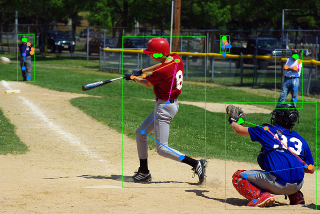

In [ ]:
from mmpose.apis import (inference_top_down_pose_model, init_pose_model,
                         vis_pose_result, process_mmdet_results)
from mmdet.apis import inference_detector, init_detector

local_runtime = False

try:
    from google.colab.patches import cv2_imshow  # for image visualization in colab
except:
    local_runtime = True

pose_checkpoint = 'work_dirs/hrnet_w32_coco_tiny_256x192/latest.pth'
det_config = 'demo/mmdetection_cfg/faster_rcnn_r50_fpn_coco.py'
det_checkpoint = 'https://download.openmmlab.com/mmdetection/v2.0/faster_rcnn/faster_rcnn_r50_fpn_1x_coco/faster_rcnn_r50_fpn_1x_coco_20200130-047c8118.pth'

# initialize pose model
pose_model = init_pose_model(cfg, pose_checkpoint)
# initialize detector
det_model = init_detector(det_config, det_checkpoint)

img = 'tests/data/coco/000000196141.jpg'

# inference detection
mmdet_results = inference_detector(det_model, img)

# extract person (COCO_ID=1) bounding boxes from the detection results
person_results = process_mmdet_results(mmdet_results, cat_id=1)

# inference pose
pose_results, returned_outputs = inference_top_down_pose_model(
    pose_model,
    img,
    person_results,
    bbox_thr=0.3,
    format='xyxy',
    dataset='TopDownCocoDataset')

# show pose estimation results
vis_result = vis_pose_result(
    pose_model,
    img,
    pose_results,
    kpt_score_thr=0.,
    dataset='TopDownCocoDataset',
    show=False)

# reduce image size
vis_result = cv2.resize(vis_result, dsize=None, fx=0.5, fy=0.5)

if local_runtime:
    from IPython.display import Image, display
    import tempfile
    import os.path as osp
    import cv2
    with tempfile.TemporaryDirectory() as tmpdir:
        file_name = osp.join(tmpdir, 'pose_results.png')
        cv2.imwrite(file_name, vis_result)
        display(Image(file_name))
else:
    cv2_imshow(vis_result)